In [ ]:
import torch  
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

In [ ]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

In [ ]:
num_workers = 0

batch_size = 20
valid_size = 0.2
transform = transforms.ToTensor()

train_data = datasets.MNIST(root='data', train=True, download=True, transform=transform)

test_data = datasets.MNIST(root='data', train=False, download=True, transform=transform)

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


In [ ]:
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size*num_train))
train_idx, valid_idx = indices[split:], indices[:split]
train_sampler, valid_sampler = SubsetRandomSampler(train_idx), SubsetRandomSampler(valid_idx)

In [ ]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
                                           sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                           sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
                                           num_workers=num_workers)


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


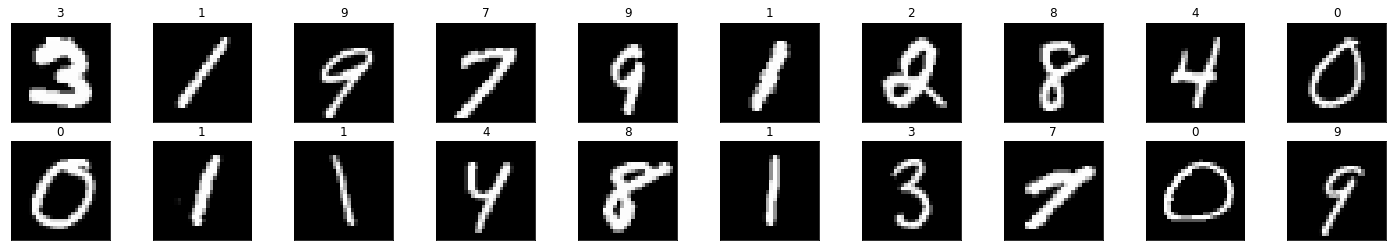

In [ ]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
  ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
  ax.imshow(np.squeeze(images[idx]), cmap='gray')
  ax.set_title(str(labels[idx].item()))

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    hidden1 = 256
    hidden2 = 256
    self.fc1 = nn.Linear(28 * 28, hidden1)
    self.fc2 = nn.Linear(hidden1, hidden2)
    self.fc3 = nn.Linear(hidden2, 10)
    self.dropout = nn.Dropout(0.2)

  def forward(self, x):
    x = x.view(-1, 28*28)
    x = F.relu(self.fc1(x))
    x = self.dropout(x)
    
    x = F.relu(self.fc2(x))
    x = self.dropout(x)

    x = self.fc3(x)
    return(x)

model = Net()
print(model)


Net(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [ ]:
len(train_loader.dataset)

60000

In [ ]:

train_loss_lst = []
val_loss_lst = []
def train(model):
  n_epochs = 50
  valid_loss_min = np.Inf
  for epoch in range(n_epochs):
    train_loss = 0.0
    valid_loss = 0.0

    model.train()

    for data, target in train_loader:
      optimizer.zero_grad()
      output = model(data)
      loss = criterion(output, target)
      loss.backward()
      optimizer.step()
      train_loss += loss.item() * data.size(0)
    
    model.eval()
    for data, target in valid_loader:
      output = model(data)
      loss = criterion(output, target)
      valid_loss += loss.item() * data.size(0)
      
    train_loss = train_loss / len(train_loader.dataset)
    valid_loss = valid_loss / len(valid_loader.dataset)
    train_loss_lst.append(train_loss)
    val_loss_lst.append(valid_loss)
    print('epoch {}, train loss {:.6f}, valid loss {:.6f}'.format(epoch+1, train_loss, valid_loss))
    
    if valid_loss <= valid_loss_min:
      print('valid loss has decreased {:.6f} --> {:.6f}. Save the model'.format(
          valid_loss_min, valid_loss))
      torch.save(model.state_dict(), 'model.pt')
      valid_loss_min = valid_loss
train(model)

epoch 1, train loss 0.825784, valid loss 0.079941
valid loss has decreased inf --> 0.079941. Save the model
epoch 2, train loss 0.306139, valid loss 0.059168
valid loss has decreased 0.079941 --> 0.059168. Save the model
epoch 3, train loss 0.240309, valid loss 0.048425
valid loss has decreased 0.059168 --> 0.048425. Save the model
epoch 4, train loss 0.202042, valid loss 0.041194
valid loss has decreased 0.048425 --> 0.041194. Save the model
epoch 5, train loss 0.170719, valid loss 0.035767
valid loss has decreased 0.041194 --> 0.035767. Save the model
epoch 6, train loss 0.149778, valid loss 0.032584
valid loss has decreased 0.035767 --> 0.032584. Save the model
epoch 7, train loss 0.132910, valid loss 0.029195
valid loss has decreased 0.032584 --> 0.029195. Save the model
epoch 8, train loss 0.119960, valid loss 0.026523
valid loss has decreased 0.029195 --> 0.026523. Save the model
epoch 9, train loss 0.108889, valid loss 0.024982
valid loss has decreased 0.026523 --> 0.024982. Sav

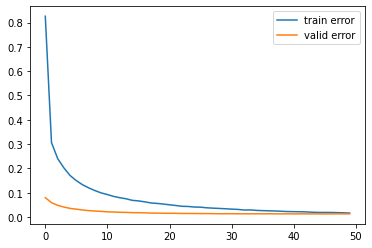

In [ ]:
plt.plot(train_loss_lst, label='train error')
plt.plot(val_loss_lst, label='valid error')
plt.legend()
plt.show()

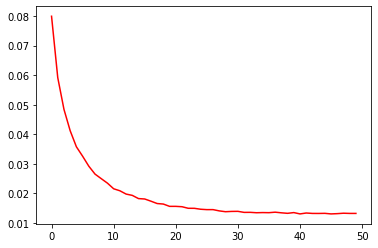

In [ ]:
plt.plot(val_loss_lst, label='valid error', c='r')
plt.show()

In [ ]:
model.load_state_dict(torch.load('model.pt'))

<All keys matched successfully>

In [ ]:
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

In [ ]:
dataiter = iter(train_loader)
data, target = dataiter.next()

In [ ]:
data.shape

torch.Size([20, 1, 28, 28])

In [ ]:
target.shape

torch.Size([20])

In [ ]:
target

tensor([4, 3, 5, 2, 5, 2, 0, 3, 4, 3, 9, 3, 9, 8, 0, 9, 9, 8, 3, 1])

In [ ]:
model.eval()

Net(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

In [ ]:
output = model(data)
output.shape

torch.Size([20, 10])

In [ ]:
output[0]

tensor([-7.2914, -2.1485, -5.7419, -6.3471, 18.9975, -0.9429, -4.1152,  0.5470,
         1.3088,  6.5260], grad_fn=<SelectBackward>)

In [ ]:
loss = criterion(output, target)
loss

tensor(0.0006, grad_fn=<NllLossBackward>)

In [ ]:
test_loss += loss.item()*data.size(0)
test_loss

0.011584720341488719

In [ ]:
_, pred = torch.max(output, 1)
pred

tensor([4, 3, 5, 2, 5, 2, 0, 3, 4, 3, 9, 3, 9, 8, 0, 9, 9, 8, 3, 1])

In [ ]:
target

tensor([4, 3, 5, 2, 5, 2, 0, 3, 4, 3, 9, 3, 9, 8, 0, 9, 9, 8, 3, 1])

In [ ]:
correct = np.squeeze(pred.eq(target.data.view_as(pred)))
correct

tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True])

In [ ]:
model.eval()
for data, target in test_loader:
  output = model(data)

  loss = criterion(output, target)
  test_loss += loss.item()*data.size(0)
  _, pred = torch.max(output, 1)

  correct = np.squeeze(pred.eq(target.data.view_as(pred)))
  for i in range(batch_size):
    label = target.data[i]
    class_correct[label] += correct[i].item()
    class_total[label] += 1

test_loss = test_loss/len(test_loader.dataset)
print('test error: {:.6f}'.format(test_loss))    

test error: 0.061485


In [ ]:
class_correct

[972.0, 1126.0, 1015.0, 997.0, 961.0, 870.0, 941.0, 1005.0, 949.0, 984.0]

In [ ]:
class_total

[980.0, 1135.0, 1032.0, 1010.0, 982.0, 892.0, 958.0, 1028.0, 974.0, 1009.0]

In [ ]:
for i in range(10):
  print('correct rate of Number {} on test set is {:5f}% ({:.0f}/{:.0f})'.
        format(i, class_correct[i]*100/class_total[i], class_correct[i], class_total[i]))

correct rate of Number 0 on test set is 99.183673% (972/980)
correct rate of Number 1 on test set is 99.207048% (1126/1135)
correct rate of Number 2 on test set is 98.352713% (1015/1032)
correct rate of Number 3 on test set is 98.712871% (997/1010)
correct rate of Number 4 on test set is 97.861507% (961/982)
correct rate of Number 5 on test set is 97.533632% (870/892)
correct rate of Number 6 on test set is 98.225470% (941/958)
correct rate of Number 7 on test set is 97.762646% (1005/1028)
correct rate of Number 8 on test set is 97.433265% (949/974)
correct rate of Number 9 on test set is 97.522299% (984/1009)


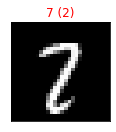

In [ ]:
# dataiter = iter(test_loader)
images, labels = dataiter.next()
output = model(images)
_, preds = torch.max(output, 1)
images = images.numpy()

fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
  if preds[idx]!=labels[idx]:
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title('{} ({})'.format(str(preds[idx].item()), str(labels[idx].item())),
               color = "red")

In [ ]:
dataiter = iter(test_loader)
images, labels = dataiter.next()
# output = model(images[0])

In [ ]:
F.softmax(output, dim=1)

tensor([[5.1788e-10, 5.2774e-11, 1.1452e-09, 6.2600e-12, 9.9999e-01, 3.5060e-07,
         1.7755e-08, 3.7052e-07, 5.7590e-06, 1.6061e-06],
        [5.3257e-08, 2.3046e-05, 7.0197e-07, 4.3302e-03, 1.9906e-05, 6.0337e-06,
         9.0823e-09, 2.0448e-04, 5.8130e-05, 9.9536e-01],
        [1.0314e-09, 9.9945e-01, 2.0867e-05, 1.5131e-06, 2.8253e-05, 4.2835e-10,
         2.9727e-07, 4.9014e-04, 7.9587e-06, 3.3917e-09],
        [7.6050e-08, 1.0011e-09, 1.0000e+00, 1.1430e-07, 1.7910e-12, 1.9631e-11,
         1.9201e-11, 6.1403e-10, 1.7286e-07, 4.3261e-13],
        [1.6855e-09, 5.5160e-09, 1.3492e-11, 1.3992e-06, 1.9639e-14, 1.0000e+00,
         4.9582e-08, 1.9493e-13, 1.6668e-09, 6.5671e-11],
        [2.7275e-07, 1.1291e-08, 8.3732e-11, 1.5102e-06, 1.1321e-09, 9.9995e-01,
         3.8836e-05, 1.8007e-11, 9.3911e-07, 7.7507e-06],
        [5.0705e-11, 7.0045e-09, 2.5805e-07, 2.5729e-05, 7.2189e-10, 8.5180e-12,
         2.6596e-15, 9.9997e-01, 1.8235e-10, 1.3608e-08],
        [8.0728e-09, 1.6433

In [ ]:
samp = np.random.rand(28, 28)

In [ ]:
samp = torch.tensor([samp]).float()

In [ ]:
model(samp)

tensor([[  0.9136,  -2.9917,   2.5369,   6.5700,  -7.8649,   5.9453,  -0.2111,
         -10.1161,   6.6822,  -0.8494]], grad_fn=<AddmmBackward>)

In [ ]:
images[0].dtype

dtype('float32')

In [ ]:
samp.dtype

torch.float32

In [ ]:
model(images[0])

tensor([[ -0.1054,  -0.4415,   3.8608,   4.9196,  -6.9985,  -2.7122, -12.9888,
          15.5207,  -2.3090,   3.3491]], grad_fn=<AddmmBackward>)